In [1]:
#SJL example script for calculating the partitioning of elements 
#using the parameterizations described in Chidester, Lock, et al. 2022

#standard python modules
import numpy as np
import scipy as sp
import sys


#plotting packages
import matplotlib as mpl
#mpl.use('PDF')
import matplotlib.pyplot as plt
import pylab
import matplotlib.cm as cm
from matplotlib import gridspec

#import the residual function
from calc_KD_res import *

#import io functions for the fits files themselves
from io_fits import *

In [2]:
##################################
#some important constants/variables

#arrays of percentiles from which to select error bounds
lower_bnd_sigma_percentiles=np.asarray([50.0,15.9,2.3,0.15])
upper_bnd_sigma_percentiles=100.0-lower_bnd_sigma_percentiles

In [3]:
#################################
#Function to double check if covariance matrix is positive semi-definite
def isPSD(cov_test, corr_test, tol=1e-8):
    E = np.linalg.eigvalsh(cov_test) #find eigenvaluesa
    
    #check for symmetry
    sym_error=np.zeros(np.shape(cov_test))
    for i in np.arange(np.size(cov_test[0,:])):
        for j in np.arange(np.size(cov_test[0,:])):
            if i!=j:
                sym_error[i,j]=np.abs(corr_test[i,j]-corr_test[j,i])
            else:
                sym_error[i,j]=0.0
    return np.all(E > -tol),np.all(sym_error<tol)

In [4]:
###################################
#PARAMS

#The names and filename references for the different fits presented in Chidester & Lock
fit_names=['no_norm_unweighted_all','Mg_diss_no_norm_unweighted_all','no_norm_unweighted_all_metal','no_norm_unweighted_abc_only']
fit_names_print=['Full fit with Mg as exchange', 'Full fit with Mg as dissociation', 'Fit with only metal terms', 'Fit with no compositional terms']

#Select the fit you want to use
ind_fit=0
print('Using '+fit_names_print[ind_fit])

#find the binary fit files associated with the selected fit
binary_fit_file=fit_names[ind_fit]+'/exLS_fits_ftest_'+fit_names[ind_fit]+'.bin'
    
#what sigma errors to report for errors
sigma=1    

#number of MC points for calculating error
NMC_calc=5000

#pressure and temperature at which to calculate the partitioning
pcalc=np.asarray([10])
Tcalc=np.asarray([2000.])

#which elements do you want to find the partitioning for ('O' and 'Fe' must be first two terms
elem_part_calc=['O','Fe','Si','Mg','S']

#the composition of the metal and silicate you want to calculate KD for (mol%). 
#list in same order as elements are specified
#O for silicate is calculated self consistently for charge balance
met_calc_user=[[0.02, 0.92, 0.05, 0.01, 0.]]
sil_calc_user=[[0., 0.02, 0.5, 0.48, 0.]]

#Other examples
# elem_part_calc=['O', 'Fe', 'Al', 'Ca', 'Mg', 'Si', 'U']
# met_calc_user=[[0.082853,   0.63738565, 0.,         0.,         0.,         \
#        0.27976135,        0.        ]]
# sil_calc_user=[[0.,         0.09494723, 0.01505161,  0.03854519,\
#      0.2065641,           0.62451705,            0.02037482 ]]

# elem_part_calc=['O', 'Fe', 'Al', 'Ca', 'K', 'Mg', 'S', 'Si']
# met_calc_user=[1.19119320e-01, 4.90837373e-01, 1.11550225e-04, 1.97405083e-04,
#                7.69821521e-05 , 1.84339601e-03, 8.27666345e-02, 3.38801874e-03]
# sil_calc_user=[0.,         0.15510004, 0.0431348,  0.04117791, 0.00771705, \
#                0.38461031, 0.0046111,  0.3636488 ]


Using Full fit with Mg as exchange


In [5]:
#read info from the binary file for the fit. 
#There is a lot of information in here that records the method behind the fit, and the data used
#More information about this file format will be released with a general fitting algorithm
(filename, Nelem, elem,elem_met, elem_sil, valence, ind_elem_disc, \
              Nelem_part, flag_elem_part,ind_elem_part,flag_term,ind_term_fit,\
             flag_LS, flag_MC, flag_norm_Nsamp_elem,flag_calc_weights,Ntest, NMC, sigma_omit,\
             lngammai0_ref, term_default,flag_term_default,\
                     Nsamp, study_names, sample_names,\
             p, T, met, sil, logK_part, logK_part_err, 
             ind_active_elem, ind_active_elem_calc,
             fits, cov, corr)=read_fit_binary(binary_fit_file)


In [7]:
#find the indices that relate the elements asked for to those in the fit file
ind_flag_calc_user=np.zeros(np.size(met_calc_user),dtype=int)

for i, name in enumerate(elem_part_calc):
    temp=np.where(elem==name)[0]
    if np.size(temp)==0:
        raise ValueError('Unknown element '+name)
    ind_flag_calc_user[i]=temp[0]

#now define the general composition and flag arrays for all elements
met_calc=np.zeros((1,Nelem))
sil_calc=np.zeros((1,Nelem))

met_calc[0,ind_flag_calc_user]=met_calc_user
sil_calc[0,ind_flag_calc_user]=sil_calc_user

flag_elem_part_calc=np.zeros(Nelem,dtype=int)
flag_elem_part_calc[ind_flag_calc_user]=1


In [21]:
#calculate logKD using the best fit coefficients
temp=partfit(fits,\
             pcalc,\
             Tcalc,\
             met_calc,\
             sil_calc,\
             np.ones((1,Nelem)),\
             np.ones((1,Nelem)),\
             flag_elem_part_calc,\
             ind_flag_calc_user,\
             flag_elem_part_calc,\
             flag_term,\
             ind_term_fit,\
             Nelem,\
             valence,\
             lngammai0_ref,\
             term_default,\
             flag_term_default,\
             np.asarray(ind_active_elem_calc),\
             ind_elem_disc,
             flag_output_mode=1,
            flag_norm_Nsamp_elem=flag_norm_Nsamp_elem)

#record the relevant values
res=temp[0]
ind_elem_store=temp[1]
ind_samp_store=temp[2]
logKcalc=temp[3]

#print the 'best fit' values
print('Values calculated with best-fit values')
print('Element \t logKD \t KD')
for i, ind in enumerate(ind_elem_store):
    if i!=1:
        print(elem[ind], logKcalc[i], 10**logKcalc[i])

Element 	 logKD 	 KD
O -0.5533897084388331 0.2796470817128199
Si -5.265787794855669 5.422657878064406e-06
Mg -3.6783583531933153 0.00020972086813918127
S 0.4742348378831629 2.9801274506826703


In [9]:
#do a random sampling of the parameters using the covariance matrix to determine 
#Median and distribution more 'correctly'
param_test=np.random.multivariate_normal(fits, cov, NMC_calc)
logKcalc_test=np.zeros((NMC_calc,np.size(ind_samp_store)))
Kcalc_test=np.zeros((NMC_calc,np.size(ind_samp_store)))

#Sometimes the normal distribution function throws an error so just need to check
temp=isPSD(cov, corr)
if temp[0]&temp[1]:
    print('Ignore positive-definite error from multivariate_normal, within tollerance')
else:
    raise ValueError('cov matrix is not positive-definite to within tolerance')

for i in np.arange(NMC_calc):
    temp=partfit(param_test[i],\
                pcalc,\
             Tcalc,\
             met_calc,\
             sil_calc,\
             np.ones((1,Nelem)),\
             np.ones((1,Nelem)),\
             flag_elem_part_calc,\
             ind_flag_calc_user,\
             flag_elem_part_calc,\
             flag_term,\
             ind_term_fit,\
             Nelem,\
             valence,\
             lngammai0_ref,\
             term_default,\
             flag_term_default,\
             np.asarray(ind_active_elem_calc),\
             ind_elem_disc,
             flag_output_mode=1,
            flag_norm_Nsamp_elem=flag_norm_Nsamp_elem)

    logKcalc_test[i,:]=temp[3]
    Kcalc_test[i,:]=10**temp[3]
    

print('done')

/var/folders/77/38y41zfd4s1b4px_dh6jjxdc0000gq/T/ipykernel_59816/1373951216.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  param_test=np.random.multivariate_normal(fits, cov, NMC_calc)


Ignore positive-definite error from multivariate_normal, within tollerance
done


In [25]:
#find the percentiles of log KD
lower_log = np.percentile(logKcalc_test, lower_bnd_sigma_percentiles[sigma], axis=0)
upper_log = np.percentile(logKcalc_test, upper_bnd_sigma_percentiles[sigma], axis=0)
median_log=np.percentile(logKcalc_test, 50., axis=0)

#and report the error
print('Distribution of values calculated with Monte Carlo')
for i, ind in enumerate(ind_elem_store):
    if i!=1:
        print('logKD_'+elem[ind]+ ' =',median_log[i],'+',upper_log[i]-median_log[i], 
              '-',median_log[i]-lower_log[i])
        
#same for KD
print()
lower = np.percentile(Kcalc_test, lower_bnd_sigma_percentiles[sigma], axis=0)
upper = np.percentile(Kcalc_test, upper_bnd_sigma_percentiles[sigma], axis=0)
median=np.percentile(Kcalc_test, 50., axis=0)

#and report the error
for i, ind in enumerate(ind_elem_store):
    if i!=1:
        print('KD_'+elem[ind]+ ' =',median[i],'+',upper[i]-median[i], '-',median[i]-lower[i])

    

Distribution of values calculated with Monte Carlo
logKD_O = -0.553397769206432 + 0.07515984690989486 - 0.07872180194338996
logKD_Si = -5.265724604464594 + 0.10023836090382332 - 0.10157600550726631
logKD_Mg = -3.6672897022947613 + 0.4893468926664397 - 0.5017812162774327
logKD_S = 0.4719984022510262 + 0.10197560474709833 - 0.09924313379474442

KD_O = 0.2796418915381906 + 0.052835470345609814 - 0.046360321659881853
KD_Si = 5.42344694031319e-06 + 1.4080166422798859e-06 - 1.1310548091029839e-06
KD_Mg = 0.00021513461727907732 + 0.00044869586444087667 - 0.00014738149685890843
KD_S = 2.9648204820868878 + 0.7846851216778732 - 0.6056720395650794


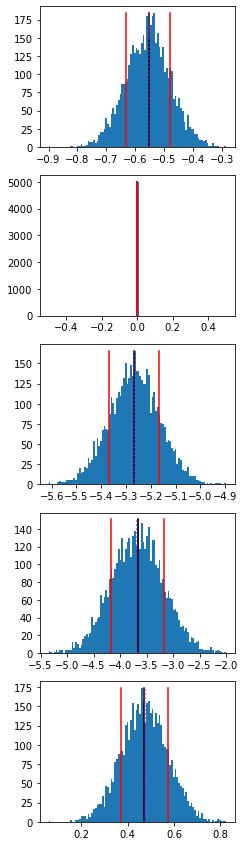

In [11]:
#Additional analysis to check error estimations etc
#plot the logKD distributions
fig = plt.figure(figsize=(3.5, 3.*np.size(ind_elem_store)))
gs = gridspec.GridSpec(np.size(ind_elem_store),1)

#make array of axes and color bars
ax =[None] * np.size(ind_elem_store)

for k in np.arange(np.size(ind_elem_store)):
    ax[k]=plt.subplot(gs[k])
    

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)

for i in np.arange(np.size(ind_elem_store)):
    hist=ax[i].hist(logKcalc_test[:,i],bins=100)
    
    ax[i].plot(median_log[i]*np.ones(2), [0,np.amax(hist[0])],'k-')
    ax[i].plot(logKcalc[i]*np.ones(2), [0,np.amax(hist[0])],'m:')
    ax[i].plot(lower_log[i]*np.ones(2), [0,np.amax(hist[0])],'r-')
    ax[i].plot(upper_log[i]*np.ones(2), [0,np.amax(hist[0])],'r-')



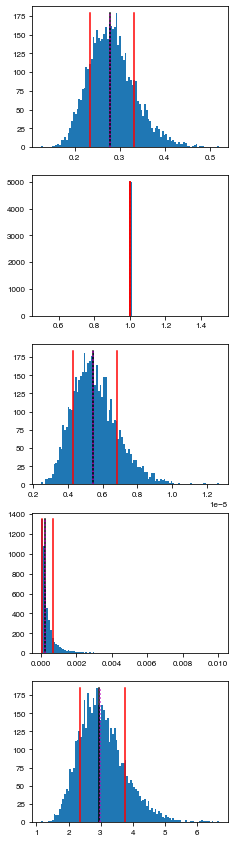

In [12]:
#Do the same for KD
#plot the result
fig = plt.figure(figsize=(3.5, 3.*np.size(ind_elem_store)))
gs = gridspec.GridSpec(np.size(ind_elem_store),1)

#make array of axes and color bars
ax =[None] * np.size(ind_elem_store)

for k in np.arange(np.size(ind_elem_store)):
    ax[k]=plt.subplot(gs[k])
    

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)

for i in np.arange(np.size(ind_elem_store)):
    hist=ax[i].hist(Kcalc_test[:,i],bins=100)
    
    ax[i].plot(median[i]*np.ones(2), [0,np.amax(hist[0])],'k-')
    ax[i].plot(10**logKcalc[i]*np.ones(2), [0,np.amax(hist[0])],'m:')
    ax[i].plot(lower[i]*np.ones(2), [0,np.amax(hist[0])],'r-')
    ax[i].plot(upper[i]*np.ones(2), [0,np.amax(hist[0])],'r-')



In [13]:
#Can also check that the error estimate has converged by looking at time evolution
median_evo_log=np.zeros((NMC_calc-1,np.size(ind_elem_store)))
lower_evo_log=np.zeros((NMC_calc-1,np.size(ind_elem_store)))
upper_evo_log=np.zeros((NMC_calc-1,np.size(ind_elem_store)))
for i in np.arange(NMC_calc-1):

    median_evo_log[i,:]=np.percentile(logKcalc_test[0:i+1,:], 50., axis=0)
    lower_evo_log[i,:] = np.percentile(logKcalc_test[0:i+1,:], lower_bnd_sigma_percentiles[sigma], axis=0)
    upper_evo_log[i,:] = np.percentile(logKcalc_test[0:i+1,:], upper_bnd_sigma_percentiles[sigma], axis=0)

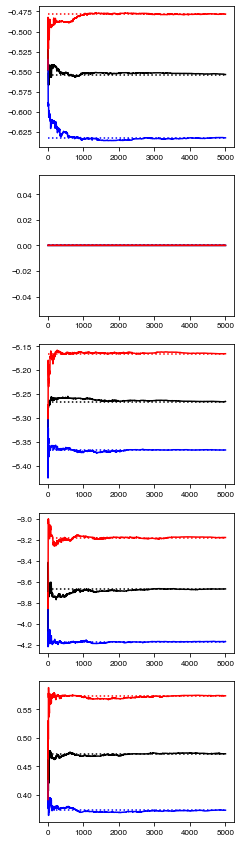

In [14]:
#plot the result
fig = plt.figure(figsize=(3.5, 3.*np.size(ind_elem_store)))
gs = gridspec.GridSpec(np.size(ind_elem_store),1)

#make array of axes and color bars
ax =[None] * np.size(ind_elem_store)

for k in np.arange(np.size(ind_elem_store)):
    ax[k]=plt.subplot(gs[k])

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)

for i in np.arange(np.size(ind_elem_store)):
    ax[i].plot(np.arange(NMC_calc-1)+1,median_evo_log[:,i],'k-')
    ax[i].plot([0,NMC_calc],median_log[i]*np.ones(2),'k:')
    
    ax[i].plot(np.arange(NMC_calc-1)+1,lower_evo_log[:,i],'b-')
    ax[i].plot([0,NMC_calc],lower_log[i]*np.ones(2),'b:')
    
    ax[i].plot(np.arange(NMC_calc-1)+1,upper_evo_log[:,i],'r-')
    ax[i].plot([0,NMC_calc],upper_log[i]*np.ones(2),'r:')

In [15]:
#and do the same for KD
median_evo=np.zeros((NMC_calc-1,np.size(ind_elem_store)))
lower_evo=np.zeros((NMC_calc-1,np.size(ind_elem_store)))
upper_evo=np.zeros((NMC_calc-1,np.size(ind_elem_store)))
for i in np.arange(NMC_calc-1):

    median_evo[i,:]=np.percentile(Kcalc_test[0:i+1,:], 50., axis=0)
    lower_evo[i,:] = np.percentile(Kcalc_test[0:i+1,:], lower_bnd_sigma_percentiles[sigma], axis=0)
    upper_evo[i,:] = np.percentile(Kcalc_test[0:i+1,:], upper_bnd_sigma_percentiles[sigma], axis=0)

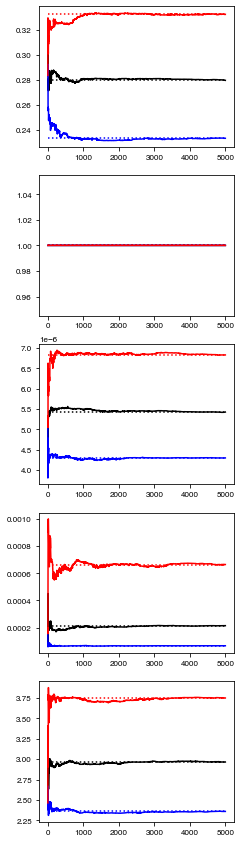

In [16]:
#plot the result
fig = plt.figure(figsize=(3.5, 3.*np.size(ind_elem_store)))
gs = gridspec.GridSpec(np.size(ind_elem_store),1)

#make array of axes and color bars
ax =[None] * np.size(ind_elem_store)

for k in np.arange(np.size(ind_elem_store)):
    ax[k]=plt.subplot(gs[k])

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)

for i in np.arange(np.size(ind_elem_store)):
    ax[i].plot(np.arange(NMC_calc-1)+1,median_evo[:,i],'k-')
    ax[i].plot([0,NMC_calc],median[i]*np.ones(2),'k:')
    
    ax[i].plot(np.arange(NMC_calc-1)+1,lower_evo[:,i],'b-')
    ax[i].plot([0,NMC_calc],lower[i]*np.ones(2),'b:')
    
    ax[i].plot(np.arange(NMC_calc-1)+1,upper_evo[:,i],'r-')
    ax[i].plot([0,NMC_calc],upper[i]*np.ones(2),'r:')